In [27]:
import sys
sys.path.insert(0, '..')
from lineage import graphs, similarity
import pandas as pd
import os
import networkx as nx
import ipywidgets
import qgrid

import matplotlib.pyplot as plt

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
#RESULT_DIR = '/home/suhail/Projects/sample_workflows/million_notebooks/selected/'
RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset/'
notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]
notebooks

['20200802-224614',
 '20200803-124938',
 '20200803-125635',
 '20200802-225006',
 '20200803-125029',
 '20200803-125246',
 '20200802-230158',
 '20200803-130249',
 '20200802-225249',
 '20200802-224624',
 '20200802-224920',
 '20200802-225038',
 '20200803-125433',
 '20200802-224609',
 '20200803-125842',
 '20200803-130030',
 '20200802-225235',
 '20200802-224518',
 '20200802-224550',
 '20200803-125023',
 '20200803-124835',
 '20200803-125503',
 '20200803-124816',
 '20200802-230134',
 '20200802-224436',
 '20200803-125912',
 '20200802-224618',
 '20200802-224535',
 '20200803-125619',
 '20200803-124957',
 '20200803-125010',
 '20200802-224539',
 '20200802-225704',
 '20200803-125006',
 '20200803-130230',
 '20200802-230008',
 '20200803-124811',
 '20200803-125035',
 '20200803-125048',
 '20200802-225114',
 '20200802-224911',
 '20200803-125202',
 '20200803-124950',
 '20200802-225730',
 '20200802-224526',
 '20200802-225333',
 '20200802-225313',
 '20200802-225056',
 '20200802-225828',
 '20200803-124839',


In [30]:
def load_result_graph_statistics(result_dir, nb, metric):
    g_truth = graphs.get_graph(RESULT_DIR, nb).to_undirected()
    g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, metric)
    
    edges_data = []
    
    for src,dst,e_data in g_infered.edges(data=True):
        edge_result = {}
        edge_result['src'] = src
        edge_result['dest'] = dst
        edge_result['notebook'] = nb
        edge_result['metric'] = metric
        edge_result['g_truth'] = g_truth.has_edge(src,dst)
        edge_result['type'] = e_data['type']
        edge_result['weight'] = e_data['weight']
        if g_truth.has_edge(src,dst):
            edge_result['operation'] = g_truth[src][dst]['operation']
            
        edges_data.append(edge_result)
        
    return pd.DataFrame(edges_data)
    
    
def ground_truth_edges(result_dir, nb, metric):
    g_truth = graphs.get_graph(RESULT_DIR, nb).to_undirected()
    g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, metric)
    
    edges_data = []
    
    for src,dst,e_data in g_truth.edges(data=True):
        edge_result = {}
        edge_result['src'] = src
        edge_result['dest'] = dst
        edge_result['notebook'] = nb
        edge_result['metric'] = metric
        edge_result['g_inferred'] = g_infered.has_edge(src,dst)
        edge_result['operation'] = e_data['operation']
        if g_infered.has_edge(src,dst):
            edge_result['type'] = g_infered[src][dst]['type']
            edge_result['weight'] = g_infered[src][dst]['weight']
            
            
        edges_data.append(edge_result)
        
    return pd.DataFrame(edges_data)

def edge_cat(truth, inferred):
    return_str = ''
    if truth:
        return_str += 'T'
    else:
        return_str += 'F'
    if inferred:
        return_str += 'P'
    else:
        return_str += 'N'
        
    return return_str

In [31]:
nb = notebooks[0]
nb

'20200802-224614'

In [32]:
import pickle 

with open(RESULT_DIR+'/'+nb+'/'+nb+'_gt_similar_nodes.pkl', 'rb') as handle:
    sim_dict = pickle.load(handle)

In [33]:
def equiv_edges(sim_dict):
    all_equiv_edges = []
    for key, value in sim_dict.items():
        equivalent_edges = [frozenset([str(key[0])+'.csv', str(key[1])+'.csv'])]
        for v in value:
            equivalent_edges.append(frozenset([str(key[0])+'.csv', str(v)+'.csv']))
        all_equiv_edges.append(equivalent_edges)
    return all_equiv_edges

def get_edge_frozensets(graph):
    edge_list = []
    for e in graph.edges():
        edge_list.append(frozenset(e))
    return edge_list
        
def find_edge_group_index(edge, equiv_edge_list):
    for i, group in enumerate(equiv_edge_list):
        if edge in group:
            #print('Equiv Edge Group Found!')
            return i
    return None

def find_gt_edge_from_equiv_group(equiv_edge_list, groupid, gt_edge_list):
    for edge in equiv_edge_list[groupid]:
        if edge in gt_edge_list:
            return edge
    return None

def compute_PR_equiv(gt_edge_list, inferred_edge_list, equiv_edge_list):
    remaining_gt_edges = gt_edge_list
    correct_edges = []
    incorrect_edges = []
    
    for e in inferred_edge_list:
        #First Check if Edge is in GT
        found = False
        if e in remaining_gt_edges:
            correct_edges.append(e)
            remaining_gt_edges.remove(e)
            to_remove_from_equiv = find_edge_group_index(e, equiv_edge_list)
            if to_remove_from_equiv:
                equiv_edge_list.pop(to_remove_from_equiv)
            found = True
        else:
            equiv_edge_group = find_edge_group_index(e, equiv_edge_list)
            if equiv_edge_group:
                print('Edge found in equiv edge group')
                correct_edges.append(e)
                remaining_gt_edges.remove(find_gt_edge_from_equiv_group(equiv_edge_list, equiv_edge_group, gt_edge_list))
                equiv_edge_list.pop(equiv_edge_group)
                found = True 
        
        if not found:
            incorrect_edges.append(e)
            
    #print(equiv_edge_list)
    
    return correct_edges, incorrect_edges, remaining_gt_edges


    
    

In [74]:
def compute_new_PR_from_result(RESULT_DIR, nb, metric):
    with open(RESULT_DIR+'/'+nb+'/'+nb+'_gt_similar_nodes.pkl', 'rb') as handle:
        sim_dict = pickle.load(handle)
        

    equiv_edge_list = equiv_edges(sim_dict)
    num_alt_edge_list = 0
    for group in equiv_edge_list:
        num_alt_edge_list += len(group) -1
    
    #print(equiv_edge_list)
    gt_list = get_edge_frozensets(graphs.get_graph(RESULT_DIR, nb).to_undirected())
    inferred_list =  get_edge_frozensets(graphs.get_graph_edge_list(RESULT_DIR, nb, metric))
    
    total_edges = len(gt_list)
    correct, to_remove, to_add = compute_PR_equiv(gt_list, inferred_list, equiv_edge_list)
    
    try:
        precision = float(len(correct))/len(inferred_list)
        recall = float(len(correct))/total_edges
        f1 = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError as e:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    
    return {'nb': nb,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'correct_edges': correct,
            'to_add': to_add,
            'to_remove': to_remove,
            'alt_edges': num_alt_edge_list,
            'total_edges': total_edges
            }



In [75]:
nb_data = []

for nb in notebooks:
    try:
        result_dict = compute_new_PR_from_result(RESULT_DIR, nb, 'pc2cellcol+group+join+pivot')
        print(nb, result_dict['F1'], result_dict['alt_edges'], result_dict['total_edges'])
        nb_data.append(result_dict)
    except (ValueError, FileNotFoundError) as e:
        #print('No result here')
        pass

20200802-224614 0.8627450980392156 2 26
20200803-124938 0.8936170212765957 3 24
20200803-125635 0.8780487804878049 11 62
20200803-125029 0.8000000000000002 4 25
20200802-230158 0.9302325581395349 5 65
20200803-130249 0.8125 10 65
20200802-224920 0.875 0 24
20200802-225038 0.9444444444444444 0 72
20200803-125433 0.782608695652174 2 71
20200802-224609 0.9130434782608695 1 23
20200803-130030 0.9022556390977443 1 67
20200802-225235 0.7424242424242424 9 66
20200802-224518 0.96 4 25
20200802-224550 0.6296296296296297 1 27
20200803-125023 0.8095238095238095 0 21
20200803-124835 0.8333333333333333 2 25
20200803-125503 0.8854961832061069 1 66
20200803-124816 0.8000000000000002 2 25
20200802-230134 0.759124087591241 3 69
20200802-224436 0.8636363636363636 1 23
20200803-125912 0.752136752136752 4 59
20200802-224618 0.8461538461538461 2 26
20200802-224535 0.8372093023255814 0 22
Edge found in equiv edge group
20200803-125619 0.7959183673469388 7 49
20200803-124957 0.8421052631578947 11 19
20200803

In [76]:
df = pd.DataFrame(nb_data)

In [77]:
df = df.sort_values('total_edges')

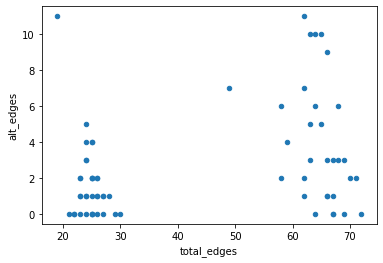

In [78]:
df.plot.scatter(x='total_edges', y='alt_edges')

In [79]:
df.sort_values('alt_edges')

,nb,Precision,Recall,F1,correct_edges,to_add,to_remove,alt_edges,total_edges
7,20200802-225038,0.944444,0.944444,0.944444,"[(41.csv, 38.csv), (51.csv, 41.csv), (42.csv, ...","[(10.csv, 5.csv), (9.csv, 10.csv), (27.csv, 40...","[(9.csv, 40.csv), (10.csv, 40.csv), (10.csv, 6...",0,72
35,20200802-224911,0.960000,0.923077,0.941176,"[(26.csv, 11.csv), (11.csv, 13.csv), (4.csv, 1...","[(9.csv, 8.csv), (17.csv, 15.csv)]","[(17.csv, 22.csv)]",0,26
53,20200803-125042,0.875000,0.840000,0.857143,"[(0.csv, 6.csv), (2.csv, 0.csv), (3.csv, 2.csv...","[(1.csv, 0.csv), (11.csv, 0.csv), (3.csv, 8.cs...","[(2.csv, 8.csv), (11.csv, 5.csv), (5.csv, 1.csv)]",0,25
42,20200802-224522,0.925926,0.925926,0.925926,"[(16.csv, 19.csv), (16.csv, 8.csv), (25.csv, 1...","[(2.csv, 0.csv), (13.csv, 7.csv)]","[(3.csv, 2.csv), (13.csv, 6.csv)]",0,27
59,20200803-125000,0.857143,0.827586,0.842105,"[(23.csv, 22.csv), (26.csv, 23.csv), (18.csv, ...","[(1.csv, 8.csv), (7.csv, 8.csv), (12.csv, 7.cs...","[(15.csv, 22.csv), (18.csv, 1.csv), (4.csv, 10...",0,29
...,...,...,...,...,...,...,...,...,...
55,20200802-225810,0.920635,0.920635,0.920635,"[(3.csv, 2.csv), (2.csv, 1.csv), (1.csv, 0.csv...","[(5.csv, 1.csv), (4.csv, 2.csv), (14.csv, 9.cs...","[(45.csv, 46.csv), (5.csv, 0.csv), (4.csv, 5.c...",10,63
52,20200803-125559,0.857143,0.843750,0.850394,"[(16.csv, 31.csv), (35.csv, 31.csv), (34.csv, ...","[(4.csv, 3.csv), (12.csv, 8.csv), (11.csv, 12....","[(23.csv, 8.csv), (25.csv, 12.csv), (11.csv, 1...",10,64
5,20200803-130249,0.825397,0.800000,0.812500,"[(14.csv, 27.csv), (14.csv, 12.csv), (13.csv, ...","[(10.csv, 1.csv), (4.csv, 3.csv), (3.csv, 5.cs...","[(1.csv, 7.csv), (4.csv, 16.csv), (11.csv, 1.c...",10,65
2,20200803-125635,0.885246,0.870968,0.878049,"[(7.csv, 22.csv), (6.csv, 7.csv), (1.csv, 7.cs...","[(2.csv, 0.csv), (15.csv, 5.csv), (9.csv, 24.c...","[(14.csv, 10.csv), (11.csv, 15.csv), (11.csv, ...",11,62


In [80]:
nb = '20200803-124957'

with open(RESULT_DIR+'/'+nb+'/'+nb+'_gt_similar_nodes.pkl', 'rb') as handle:
        sim_dict = pickle.load(handle)
        
sim_dict

{(14, '16'): [15], (5, '17'): [2, 3, 6, 7, 8, 9, 10, 14, 15, 16]}